### Imports

In [1]:
import os
import sys
import random

In [2]:
import time

In [3]:
import numpy as np

In [4]:
import torch
from torch.utils.data import Dataset

In [5]:
from torch import nn

In [6]:
import torchvision
import torchvision.transforms as transforms

In [7]:
from torchvision.transforms import InterpolationMode

In [ ]:
# наша библиотека
from svetlanna import SimulationParameters
from svetlanna.parameters import BoundedParameter

In [ ]:
# наша библиотека
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [10]:
from svetlanna.transforms import ToWavefront

In [ ]:
# выборка данных волновых фронтов
from src.wf_datasets import DatasetOfWavefronts
from src.wf_datasets import IlluminatedApertureDataset

In [12]:
from tqdm import tqdm

In [13]:
import json

In [14]:
from datetime import datetime

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Оптическая нейронная сеть

В этом примере реализованы несколько экспериментов, основанных на оптической нейронной сети с архитектурой из этой [статьи](https://www.science.org/doi/10.1126/science.aat8084).

# 0. Экспериментальные параметры

In [ ]:
working_frequency = 0.4 * 1e12 # [Гц]
C_CONST = 299_792_458  # [м / с]

In [ ]:
# список всех сохраненных моделей
dir_models = 'models/03_mnist_experiments'

filepathes = []

for file in os.listdir(dir_models):
    filename = os.fsdecode(file)
    if not filename.endswith(".pth"):
        filepathes.append(filename)

print(*sorted(filepathes), sep='\n')

.DS_Store
09-12-2024_experiment_01
13-12-2024_experiment_01
22-11-2024_experiment_01
22-11-2024_experiment_02
22-11-2024_experiment_03
27-11-2024_experiment_01


In [18]:
EXP_NUMBER = 1
load_date = '13-12-2024'  # datetime.today().strftime('%d-%m-%Y')

In [19]:
RESULTS_FOLDER = (
    f'{dir_models}/{load_date}_experiment_{EXP_NUMBER:02d}'
)

RESULTS_FOLDER

'models/03_mnist_experiments/13-12-2024_experiment_01'

In [20]:
# save experiment conditions
# json.dump(EXP_CONDITIONS, open(f'{RESULTS_FOLDER}/conditions.json', 'w'))

In [ ]:
# ИЛИ загружаем условия эксперимента из файла:
EXP_CONDITIONS = json.load(open(f'{RESULTS_FOLDER}/conditions.json'))
EXP_CONDITIONS

{'wavelength': 0.000749481145,
 'layer_size_m': 0.12,
 'layer_nodes': 150,
 'tensorboard': True,
 'digit_resize': 17,
 'ds_apertures': True,
 'ds_modulation': None,
 'gauss_waist_radius': 0.02,
 'distance_to_aperture': 0.03,
 'propagator': 'AS',
 'n_diff_layers': 5,
 'diff_layer_max_phase': 3.141592653589793,
 'diff_layer_mask_init': 'const',
 'diff_layers_seeds': 123,
 'layers_distance': 0.03,
 'add_apertures': True,
 'apertures_size': [50, 50],
 'detector_zones': 'segments',
 'detector_transpose': False,
 'train_bs': 8,
 'val_bs': 20,
 'train_split_seed': 178,
 'epochs': 10}

# 1. Параметры симуляции

In [ ]:
working_wavelength = EXP_CONDITIONS['wavelength']  # [м]
print(f'Длина волны = {working_wavelength * 1e6:.3f} нм')

lambda = 749.481 um


In [ ]:
# физические размеры слоев(из статьи)
x_layer_size_m = EXP_CONDITIONS['layer_size_m']  # [m]
y_layer_size_m = x_layer_size_m

In [ ]:
# количество нейронов в симуляции
x_layer_nodes = EXP_CONDITIONS['layer_nodes']
y_layer_nodes = x_layer_nodes

In [ ]:
print(f'Размер слоя в нейронах: {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (neurons): 150 x 150 = 22500


In [ ]:
neuron_size = x_layer_size_m / x_layer_nodes  # [м]  увеличиваем в два раза!
print(f'Размер нейрона = {neuron_size * 1e6:.3f} нм')

Neuron size = 800.000 um


In [ ]:

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Подготовка выборки данных (Инженер данных)

## 2.1. [Выборка данных MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset): загрузка и преобразование в волновые фронты

In [ ]:
# инициализируем директорию для набора данных
MNIST_DATA_FOLDER = './data'

### 2.1.1. Загрузка тренировочной и тестовой выборок изображений

In [ ]:
# тренировочная выборка MNIST
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # для тренировочной выборки
    download=False,
)

In [ ]:
# тестовая выборка MNIST
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # для тестовой выборки
    download=False,
)

In [ ]:
print(f'Размер тренировочной выборки: {len(mnist_train_ds)}')
print(f'Размер тестовой выборки: {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Создание тренировочной и тестовой выборок волновых фронтов

In [ ]:
DS_WITH_APERTURES = EXP_CONDITIONS['ds_apertures']
# if True будем использовать IlluminatedApertureDataset для создания выборок волновых фронтов
# else - DatasetOfWavefronts
DS_WITH_APERTURES

True

In [ ]:
# выбор типа модуляции DatasetOfWavefronts if DS_WITH_APERTURES == False
MODULATION_TYPE = EXP_CONDITIONS['ds_modulation']  # 'phase', 'amp', 'amp&phase'

# выбор метода и дистанции для FreeSpace в IlluminatedApertureDataset
DS_METHOD = EXP_CONDITIONS['propagator']
DS_DISTANCE = EXP_CONDITIONS['distance_to_aperture']  # [m]

DS_BEAM = Wavefront.gaussian_beam(
    simulation_parameters=SIM_PARAMS,
    waist_radius=EXP_CONDITIONS['gauss_waist_radius'],  # [m]
)

In [ ]:
# изменяем размер изображения, чтобы он совпадал с SimulationParameters
resize_y = EXP_CONDITIONS['digit_resize']
resize_x = resize_y  # shape for transforms.Resize

pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [ ]:
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # левый отступ
              pad_top,  # верхний отступ
              pad_right,  # правый отступ
              pad_bottom  # нижний отступ
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- выбираем тип модуляции!!!
  ]
)

# compose all transforms for IlluminatedApertureDataset
image_to_aperture = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # левый отступ
              pad_top,  # верхний отступ
              pad_right,  # правый отступ
              pad_bottom  # нижний отступ
          ),
          fill=0,
      ),  # padding to match sizes!
  ]
)

In [ ]:
# Тренировочный набор данных волновых фронтов
if not DS_WITH_APERTURES:
    mnist_wf_train_ds = DatasetOfWavefronts(
        init_ds=mnist_train_ds,  # выборка изображений
        transformations=image_transform_for_ds,  # преобразование изображений
        sim_params=SIM_PARAMS,  # параметры симуляции
    )
else:
    mnist_wf_train_ds = IlluminatedApertureDataset(
        init_ds=mnist_train_ds,  # выборка изображений
        transformations=image_to_aperture,  # преобразование изображений
        sim_params=SIM_PARAMS,  # параметры симуляции
        beam_field=DS_BEAM,
        distance=DS_DISTANCE,
        method=DS_METHOD,
    )

In [ ]:
# Тестовый набор данных волновых фронтов
if not DS_WITH_APERTURES:
    mnist_wf_test_ds = DatasetOfWavefronts(
        init_ds=mnist_test_ds,  # выборка изображений
        transformations=image_transform_for_ds,  # преобразование изображений
        sim_params=SIM_PARAMS,  # параметры симуляции
    )
else:
    mnist_wf_test_ds = IlluminatedApertureDataset(
        init_ds=mnist_test_ds,  # выборка изображений
        transformations=image_to_aperture,  # преобразование изображений
        sim_params=SIM_PARAMS,  # параметры симуляции
        beam_field=DS_BEAM,
        distance=DS_DISTANCE,
        method=DS_METHOD,
    )

# 3. Оптическая сеть

In [ ]:
NUM_OF_DIFF_LAYERS = EXP_CONDITIONS['n_diff_layers']  # количество дифракционных слоев
FREE_SPACE_DISTANCE = EXP_CONDITIONS['layers_distance']  # [м]

## 3.1. Архитектура

### 3.1.1. Список элементов

> Для помощи в создании 3d-печати и конструкции $D^2NN$, использована функция сигмоиды для ограничения значения фазового набега каждого нейрона до $0-2π$ и $0-π$, для сетей визуализации и классификаторов соответственно.

In [41]:
MAX_PHASE = EXP_CONDITIONS['diff_layer_max_phase']

In [42]:
from src.for_setup import get_const_free_space, get_random_diffractive_layer
from torch.nn import functional

Функция для создания списка элементов:

In [ ]:
# добавим апертуры перед каждым дифракционным слоем
ADD_APERTURES = EXP_CONDITIONS['add_apertures']
APERTURE_SZ = EXP_CONDITIONS['apertures_size']

In [ ]:
def get_elements_list(
    num_layers,
    simulation_parameters: SimulationParameters,
    freespace_method,
    masks_seeds,
    apertures=False,
    aperture_size=(100, 100)
):
    """
    Composes a list of elements for setup.
        Optical system: FS|DL|FS|...|FS|DL|FS|Detector
    ...

    Parameters
    ----------
    num_layers : int
        Number of layers in the system.
    simulation_parameters : SimulationParameters()
        A simulation parameters for a task.
    freespace_method : str
        Propagation method for free spaces in a setup.
    masks_seeds : torch.Tensor()
        Torch tensor of random seeds to generate masks for diffractive layers.

    Returns
    -------
    elements_list : list(Element)
        List of Elements for an optical setup.
    """
    elements_list = []  # list of elements

    if apertures:  # эквивалентные маски для всех апертур (выбираем часть в середине)
        aperture_mask = torch.ones(size=aperture_size)

        y_nodes, x_nodes = simulation_parameters.axes_size(axs=('H', 'W'))
        y_mask, x_mask = aperture_mask.size()
        pad_top = int((y_nodes - y_mask) / 2)
        pad_bottom = y_nodes - pad_top - y_mask
        pad_left = int((x_nodes - x_mask) / 2)
        pad_right = x_nodes - pad_left - x_mask  # параметры для transforms.Pad

        # преобразование отступов для соответствия размерам параметров симуляции
        aperture_mask = functional.pad(
            input=aperture_mask,
            pad=(pad_left, pad_right, pad_top, pad_bottom),
            mode='constant',
            value=0
        )

    # собираем архитектуру системы
    for ind_layer in range(num_layers):
        if ind_layer == 0:
            # первый FreeSpace перед первым DiffractiveLayer
            elements_list.append(
                get_const_free_space(
                    simulation_parameters,
                    FREE_SPACE_DISTANCE,  # в [м]
                    freespace_method=freespace_method,
                )
            )

        # добавляем апертуры перед каждым дифракционным слоем
        if apertures:
            elements_list.append(
                elements.Aperture(
                    simulation_parameters=simulation_parameters,
                    mask=nn.Parameter(aperture_mask, requires_grad=False)
                )
            )

        # добавляем DiffractiveLayer
        elements_list.append(
            get_random_diffractive_layer(
                simulation_parameters,
                mask_seed=masks_seeds[ind_layer].item(),
                max_phase=MAX_PHASE
            )
        )
        # добавляем FreeSpace
        elements_list.append(
            get_const_free_space(
                simulation_parameters,
                FREE_SPACE_DISTANCE,  # в [м]
                freespace_method=freespace_method,
            )
        )

    # добавляем детектор в конец системы!
    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'  # детектор возвращает интенсивность волнового фронта
        )
    )

    return elements_list

Ограничения для инициализации системы:

In [ ]:
FREESPACE_METHOD = EXP_CONDITIONS['propagator'] # TODO: 'AS' returns nan's?

if EXP_CONDITIONS['diff_layer_mask_init'] == 'random':
    MASKS_SEEDS = torch.randint(
        low=0, high=100,
        size=(NUM_OF_DIFF_LAYERS,),
        generator=torch.Generator().manual_seed(EXP_CONDITIONS['diff_layers_seeds'])  # для генерации такого же множества начальных масок
    )  # для одинаковой случайной генерации

if EXP_CONDITIONS['diff_layer_mask_init'] == 'const':
    MASKS_SEEDS = torch.ones(size=(NUM_OF_DIFF_LAYERS,)) * torch.pi / 2  # начальная константная инициализация масок

MASKS_SEEDS

tensor([1.5708, 1.5708, 1.5708, 1.5708, 1.5708])

### 3.1.2. Составляем `LinearOpticalSetup`

In [ ]:
def get_setup(
    simulation_parameters,
    num_layers,
    apertures=False,
    aperture_size=(100,100)
):
    """
    Returns an optical setup. Recreates all elements.
    """
    elements_list = get_elements_list(
        num_layers,
        simulation_parameters,
        FREESPACE_METHOD,
        MASKS_SEEDS,
        apertures=apertures,
        aperture_size=aperture_size
    )  # пересоздаем элементы системы

    return LinearOpticalSetup(elements=elements_list)

In [ ]:
lin_optical_setup = get_setup(
    SIM_PARAMS,
    NUM_OF_DIFF_LAYERS,
    apertures=ADD_APERTURES,
    aperture_size=APERTURE_SZ
)
# Комментарий: Lin - фамилия первого автора статьи

In [48]:
lin_optical_setup.net

Sequential(
  (0): FreeSpace()
  (1): Aperture()
  (2): DiffractiveLayer()
  (3): FreeSpace()
  (4): Aperture()
  (5): DiffractiveLayer()
  (6): FreeSpace()
  (7): Aperture()
  (8): DiffractiveLayer()
  (9): FreeSpace()
  (10): Aperture()
  (11): DiffractiveLayer()
  (12): FreeSpace()
  (13): Aperture()
  (14): DiffractiveLayer()
  (15): FreeSpace()
  (16): Detector()
)

### 3.1.3 Обработчик детектора

In [49]:
number_of_classes = 10

In [50]:
import src.detector_segmentation as detector_segmentation
# Functions to segment detector: squares_mnist, circles, angular_segments

In [51]:
if ADD_APERTURES or APERTURE_SZ:
    y_detector_nodes, x_detector_nodes = APERTURE_SZ
else:
    y_detector_nodes, x_detector_nodes = SIM_PARAMS.axes_size(axs=('H', 'W'))

In [52]:
ADD_APERTURES

True

#### Маска детектора (квадратные зоны)

In [ ]:
detector_squares_mask = detector_segmentation.squares_mnist(
    y_detector_nodes, x_detector_nodes,  # размер детектора или апертуры (в середине детектора)
    SIM_PARAMS
)

#### Маска детектора (круглые зоны)

In [ ]:
detector_circles_mask = detector_segmentation.circles(
    y_detector_nodes, x_detector_nodes,  # размер детектора или апертуры (в середине детектора)
    number_of_classes,
    SIM_PARAMS
)

#### маска детектора (зоны - угловые сегменты)

In [ ]:
detector_angles_mask = detector_segmentation.angular_segments(
    y_detector_nodes, x_detector_nodes,  # размер детектора или апертуры (в середине детектора)
    number_of_classes,
    SIM_PARAMS
)

#### Обработчик детектора

In [56]:
CIRCLES_ZONES = EXP_CONDITIONS['detector_zones'] == 'circles'
CIRCLES_ZONES

False

In [57]:
if EXP_CONDITIONS['detector_zones'] == 'circles':
    selected_mask = detector_circles_mask
    print('circles selected!')

if EXP_CONDITIONS['detector_zones'] == 'squares':
    selected_mask = detector_squares_mask
    print('squares selected!')

if EXP_CONDITIONS['detector_zones'] == 'segments':
    selected_mask = detector_angles_mask
    print('angular segments selected!')

if EXP_CONDITIONS['detector_zones'] == 'strips':
    selected_mask = None
    print('strips selected!')

angular segments selected!


In [58]:
detector_processor = DetectorProcessorClf(
    num_classes=number_of_classes,
    simulation_parameters=SIM_PARAMS,
    segmented_detector=selected_mask,  # choose a mask!
    segments_zone_size=APERTURE_SZ
)

In [59]:
if 'detector_transpose' in EXP_CONDITIONS.keys():
    if EXP_CONDITIONS['detector_transpose']:
        detector_processor.segmented_detector = detector_processor.segmented_detector.T

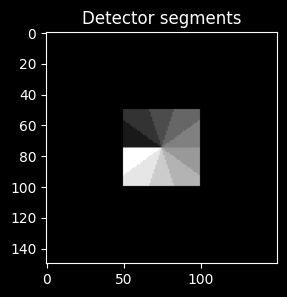

In [60]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(detector_processor.segmented_detector, cmap='grey')

plt.show()

#### Визуализация зон детектора

In [61]:
ZONES_HIGHLIGHT_COLOR = 'w'
ZONES_LW = 0.5
selected_detector_mask = detector_processor.segmented_detector.clone().detach()

In [ ]:
def get_zones_patches(detector_mask):
    """
    Returns a list of patches to draw zones in final visualisation
    """
    zones_patches = []

    if EXP_CONDITIONS['detector_zones'] == 'circles':
        for ind_class in range(number_of_classes):
            # use `circles_radiuses`, `x_layer_size_m`, `x_layer_nodes`
            rad_this = (circles_radiuses[ind_class] / x_layer_size_m * x_layer_nodes)

            zone_circ = patches.Circle(
                (x_layer_nodes / 2, y_layer_nodes / 2),
                rad_this,
                linewidth=ZONES_LW,
                edgecolor=ZONES_HIGHLIGHT_COLOR,
                facecolor='none'
            )

            zones_patches.append(zone_circ)
    else:
        if EXP_CONDITIONS['detector_zones'] == 'segments':
            class_segment_angle = 2 * torch.pi / number_of_classes
            len_lines_nodes = int(x_layer_nodes / 2)

            delta = 0.5
            idx_y, idx_x = (detector_mask > -1).nonzero(as_tuple=True)
            zone_rect = patches.Rectangle(
                (idx_x[0] - delta, idx_y[0] - delta),
                idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta,
                linewidth=ZONES_LW,
                edgecolor=ZONES_HIGHLIGHT_COLOR,
                facecolor='none'
            )
            zones_patches.append(zone_rect)

            ang = torch.pi
            x_center, y_center = int(x_layer_nodes / 2), int(y_layer_nodes / 2)
            for ind_class in range(number_of_classes):
                path_line = Path(
                    [
                        (x_center, y_center),
                        (
                            x_center + len_lines_nodes * np.cos(ang),
                            y_center + len_lines_nodes * np.sin(ang)
                        ),
                    ],
                    [
                        Path.MOVETO,
                        Path.LINETO
                    ]
                )
                bound_line = patches.PathPatch(
                    path_line,
                    facecolor='none',
                    lw=ZONES_LW,
                    edgecolor=ZONES_HIGHLIGHT_COLOR,
                )

                zones_patches.append(bound_line)

                ang += class_segment_angle
        else:
            delta = 0.5

            for ind_class in range(number_of_classes):
                idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)

                zone_rect = patches.Rectangle(
                    (idx_x[0] - delta, idx_y[0] - delta),
                    idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta,
                    linewidth=ZONES_LW,
                    edgecolor=ZONES_HIGHLIGHT_COLOR,
                    facecolor='none'
                )

                zones_patches.append(zone_rect)

    return zones_patches

# 4. Сеть

Объекты в данный момент:
- `lin_optical_setup` : `LinearOpticalSetup` – линейная оптическая нейронная сеть состоящая из Elements
- `detector_processor` : `DetectorProcessorClf` – этот слой обрабатывает изображение с детектора и рассчитывает вероятности принадлежности к классам.

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# if DEVICE == torch.device('cpu'):
#     DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

DEVICE

device(type='cpu')

## 4.1. Некоторые обязательные действия

### 4.1.1. `DataLoader`'s

In [ ]:
train_bs = EXP_CONDITIONS['train_bs']  # размер батча для обучения
val_bs = EXP_CONDITIONS['val_bs']

> Для этой задачи были разработаны маски пропускания фазы путем обучения пятислойной нейронной сети $D^2$ с $55000$ изображениями ($5000$ проверочными изображениями) из базы данных рукописных цифр MNIST (Модифицированный Национальный институт стандартов и технологий).

In [ ]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # размер из статьи
    generator=torch.Generator().manual_seed(EXP_CONDITIONS['train_split_seed'])  # для воспроизводимости
)

In [66]:
train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

In [71]:
test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=10,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)  # data loader for a test MNIST data

### 4.1.2. Оптимизатор и функция потерь

Информация из [приложения](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) для классификации MNIST:


> Мы использовали алгоритм стохастического градиентного спуска Adam для обратного распространения ошибок и обновления
слоев сети для минимизации функции потерь.

In [67]:
loss_func_clf = nn.CrossEntropyLoss()
loss_func_name = 'CE loss'

### 4.1.3. Циклы обучения и оценки

In [68]:
from src.clf_loops import onn_train_clf, onn_validate_clf

# 5. Загрузка результатов экспериментов

In [ ]:
# путь для сохранения модели
load_model_subfolder = f'{load_date}_experiment_{EXP_NUMBER:02d}'
load_model_filepath = f'{dir_models}/{load_model_subfolder}/optical_setup_net.pth'

load_model_filepath

'models/03_mnist_experiments/13-12-2024_experiment_01/optical_setup_net.pth'

In [74]:
RESULTS_FOLDER

'models/03_mnist_experiments/13-12-2024_experiment_01'

In [ ]:
# условия эксперимента
conditions_load = json.load(open(f'{RESULTS_FOLDER}/conditions.json'))
conditions_load

{'wavelength': 0.000749481145,
 'layer_size_m': 0.12,
 'layer_nodes': 150,
 'tensorboard': True,
 'digit_resize': 17,
 'ds_apertures': True,
 'ds_modulation': None,
 'gauss_waist_radius': 0.02,
 'distance_to_aperture': 0.03,
 'propagator': 'AS',
 'n_diff_layers': 5,
 'diff_layer_max_phase': 3.141592653589793,
 'diff_layer_mask_init': 'const',
 'diff_layers_seeds': 123,
 'layers_distance': 0.03,
 'add_apertures': True,
 'apertures_size': [50, 50],
 'detector_zones': 'segments',
 'detector_transpose': False,
 'train_bs': 8,
 'val_bs': 20,
 'train_split_seed': 178,
 'epochs': 10}

In [ ]:
# система для загрузки весов
optical_setup_loaded = get_setup(
    SIM_PARAMS,
    NUM_OF_DIFF_LAYERS,
    apertures=ADD_APERTURES,
    aperture_size=APERTURE_SZ
)

# загрузка весов
optical_setup_loaded.net.load_state_dict(torch.load(load_model_filepath))

/var/folders/mt/0w6nmsr119bb2g4h4xrv9p6m0000gn/T/ipykernel_1676/3316892598.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optical_setup_loaded.net.load_state_dict(torc

<All keys matched successfully>

## 5.1. Кривые обучения

In [77]:
losses_data = np.genfromtxt(
    f'{RESULTS_FOLDER}/training_curves.csv',
    delimiter=','
)

In [78]:
n_epochs = conditions_load['epochs']
(train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc) = losses_data[1:, :].T

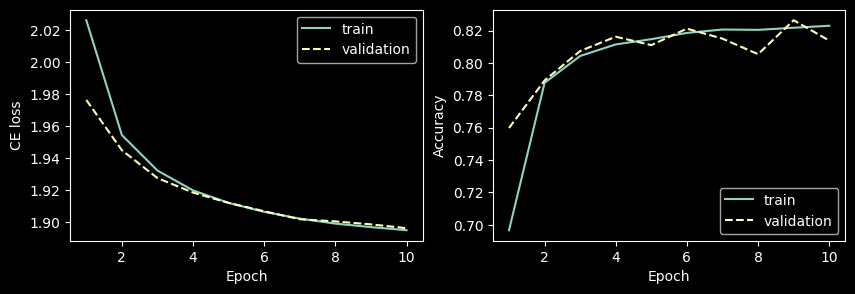

In [ ]:
# кривые обучения
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, n_epochs + 1), train_epochs_losses, label='train')
axs[0].plot(range(1, n_epochs + 1), val_epochs_losses, linestyle='dashed', label='validation')

axs[1].plot(range(1, n_epochs + 1), train_epochs_acc, label='train')
axs[1].plot(range(1, n_epochs + 1), val_epochs_acc, linestyle='dashed', label='validation')

axs[0].set_ylabel(loss_func_name)
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.show()

## 5.3. Обученные маски

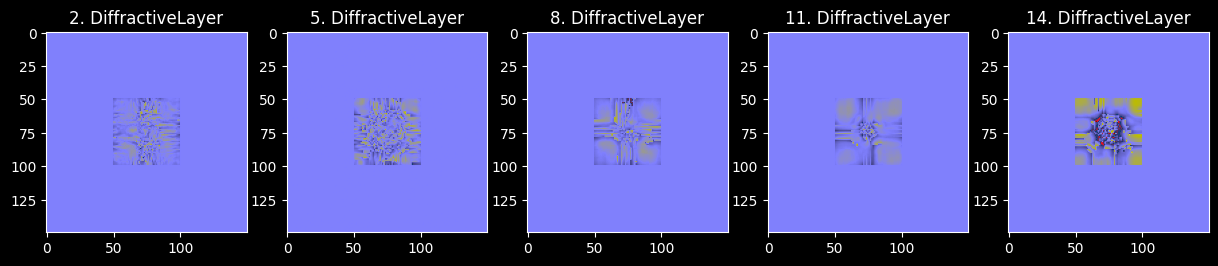

In [ ]:
n_cols = NUM_OF_DIFF_LAYERS  # количество колонок для визуализации масок DiffractiveLayer'
n_rows = 1

# строим фазы волнового фронта
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

cmap = 'gist_stern'

for ind_layer, layer in enumerate(optical_setup_loaded.net):
    if isinstance(layer, elements.DiffractiveLayer):  # строим маски для дифракционных слоев
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_layer}. DiffractiveLayer')

        trained_mask = layer.mask.detach()

        # mask_seed = MASKS_SEEDS[ind_diff_layer].item()
        # random_mask = torch.rand(
        #     size=(sim_params.y_nodes, sim_params.x_nodes),
        #     generator=torch.Generator().manual_seed(mask_seed)
        # ) * (MAX_PHASE)

        ax_this.imshow(
            trained_mask, cmap=cmap,
            vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

plt.show()

## 5.4. Метрики для тестовой выборки

In [ ]:
test_losses_1, _, test_accuracy_1 = onn_validate_clf(
    optical_setup_loaded.net,  # оптическая сеть с загруженными весами
    test_wf_loader,  # загрузчик тестовой выборки
    detector_processor,  # обработчик детектора
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # оценка модели

print(
    'Результаты после обучения на тестовой выборке:\n' +
    f'\t{loss_func_name} : {np.mean(test_losses_1):.6f}\n' +
    f'\tТочность: {(test_accuracy_1 * 100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 30.07it/s]

Results after training on TEST set:
	CE loss : 1.889739
	Accuracy : 82.3 %


## 5.5. Пример классификации(распространение)

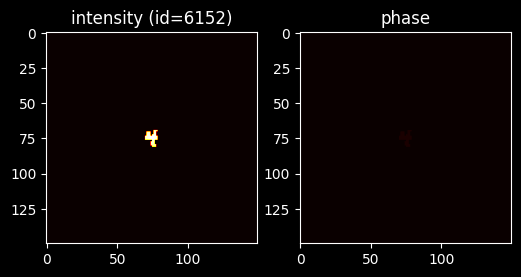

In [82]:
# plot an image
# '1' - 3214, good
# '4' - 6152, good
# '6' - 123, good
# '8' - 128, good
# '0' - 3, good
ind_test = 6152
cmap = 'hot'

fig, axs = plt.subplots(1, 2, figsize=(2 * 3, 3))

test_wavefront, test_target = mnist_wf_test_ds[ind_test]

axs[0].set_title(f'intensity (id={ind_test})')
axs[0].imshow(test_wavefront.intensity[0], cmap=cmap)

axs[1].set_title(f'phase')
axs[1].imshow(
    test_wavefront.phase[0], cmap=cmap,
    vmin=0, vmax=2 * torch.pi
)

plt.show()

In [ ]:
# распространение примера через обученную сеть
setup_scheme, test_wavefronts = optical_setup_loaded.stepwise_forward(test_wavefront)

### 5.5.1. Амплитудные профили

-(0)-> [1. FreeSpace] -(1)-> [2. Aperture] -(2)-> [3. DiffractiveLayer] -(3)-> [4. FreeSpace] -(4)-> [5. Aperture] -(5)-> [6. DiffractiveLayer] -(6)-> [7. FreeSpace] -(7)-> [8. Aperture] -(8)-> [9. DiffractiveLayer] -(9)-> [10. FreeSpace] -(10)-> [11. Aperture] -(11)-> [12. DiffractiveLayer] -(12)-> [13. FreeSpace] -(13)-> [14. Aperture] -(14)-> [15. DiffractiveLayer] -(15)-> [16. FreeSpace] -(16)-> [17. Detector] -(17)->


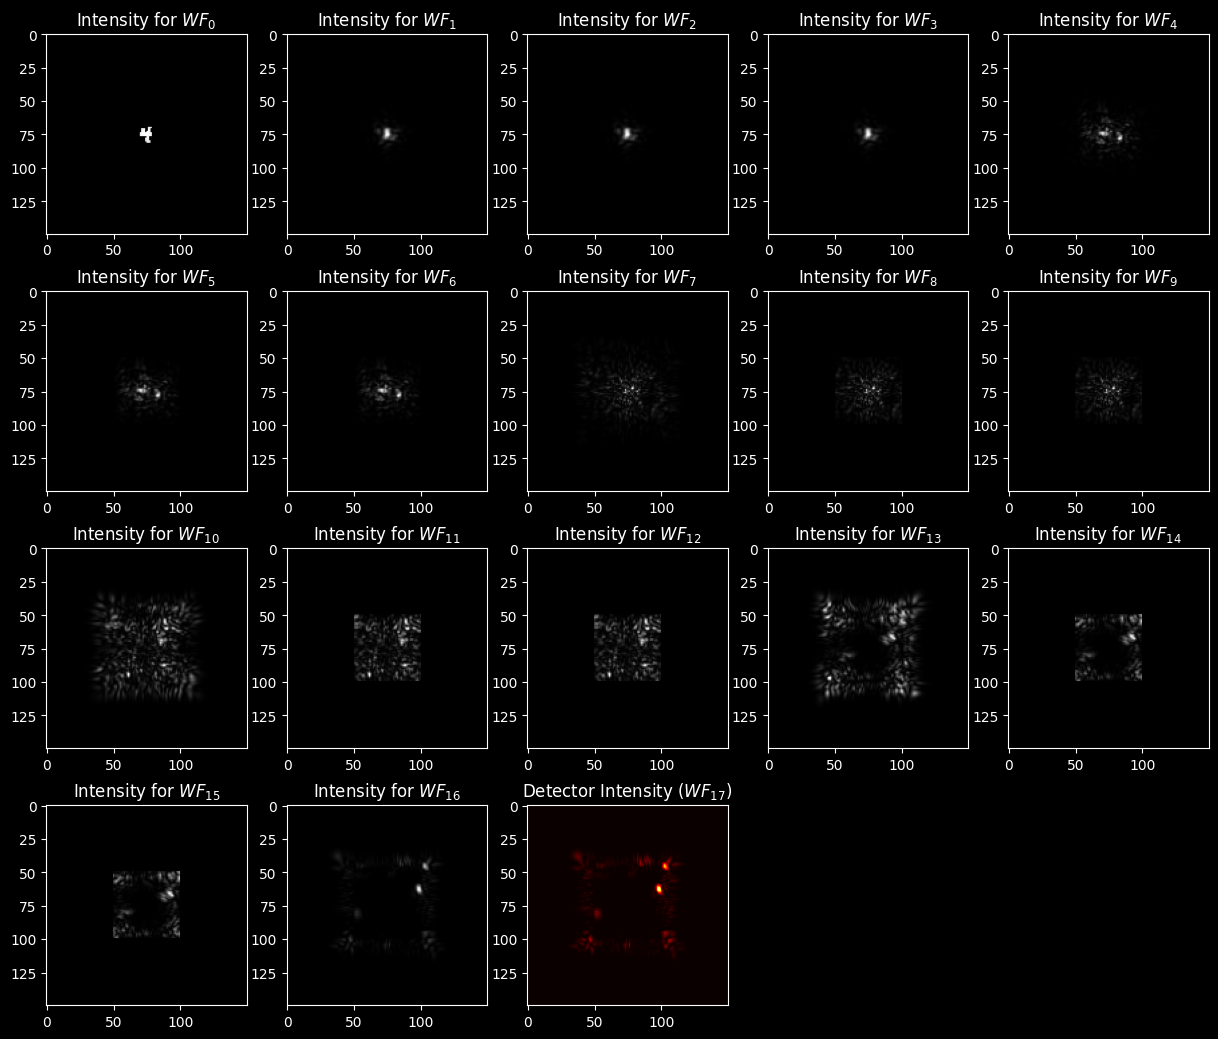

In [ ]:
print(setup_scheme)  # вывод схемы системы

n_cols = 5  # количество колонок для визуализации волновых фронтов во время распространения
n_rows = (len(optical_setup_loaded.net) // n_cols) + 1

to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'  # choose colormaps
detector_cmap = 'hot'

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# выключаем ненужные оси
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(test_wavefronts):
            ax_this.axis('off')

# plot wavefronts
for ind_wf, wavefront in enumerate(test_wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    if to_plot == 'phase':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Фаза для $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].phase.detach().numpy(), cmap=cmap,
                vmin=0, vmax=2 * torch.pi
            )
        else:  # (не wavefront!)
            ax_this.set_title('Фаза детектора ($WF_{' + f'{ind_wf}' + '})$')
            # у детектора нет фазы!

    if to_plot == 'amp':

        if ind_wf < len(test_wavefronts) - 1:
            ax_this.set_title('Интенсивность для $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].intensity.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
        else:  # выход детектора (не wavefront!)
            ax_this.set_title('Интенсивность детектора ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront[0].detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )

    # Комментарий: выход Detector является тензором! У него нет методов объекта Wavefront (например .phase или .intensity)!

plt.show()

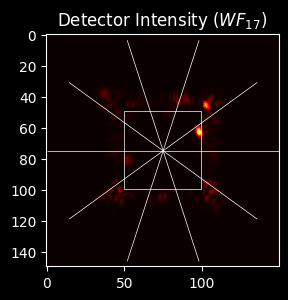

In [ ]:
# создаем фигуру с графиками
fig, ax_this = plt.subplots(1, 1, figsize=(3, 3.2))

# выход детектора (не wavefront!)
ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
ax_this.imshow(
    test_wavefronts[-1][0].detach().numpy(), cmap='hot',
    # vmin=0, vmax=1  # uncomment to make the same limits
)

for zone in get_zones_patches(selected_detector_mask):
    # add zone's patches to the axis
    # zone_copy = copy(zone)
    ax_this.add_patch(zone)

plt.show()

### 5.5.2. Вероятности

In [ ]:
# получаем вероятности классов для последнего волнового фронта
test_probas = detector_processor.forward(test_wavefronts[-1])

for label, prob in enumerate(test_probas[0]):
    print(f'{label} : {prob * 100:.2f}%')

0 : 0.85%
1 : 4.22%
2 : 5.14%
3 : 1.11%
4 : 64.29%
5 : 2.39%
6 : 1.11%
7 : 1.32%
8 : 0.70%
9 : 18.87%


## 5.6. Энергетическая эффективность _эффективность_

In [ ]:
targets_test_lst = []
preds_test_lst = []

detector_sums_by_classes = [
    torch.zeros(size=SIM_PARAMS.axes_size(axs=('H', 'W'))) for _ in range(number_of_classes)
]
samples_by_classes = [0 for _ in range(number_of_classes)]
probas_sums_by_classes = [
    torch.zeros(number_of_classes) for _ in range(number_of_classes)
]

# цикл над тествой выборкой
for ind, (wavefront_this, target_this) in enumerate(tqdm(mnist_wf_test_ds)):
    optical_setup_loaded.net.eval()

    batch_wavefronts = torch.unsqueeze(wavefront_this, 0)
    batch_labels = torch.unsqueeze(torch.tensor(target_this), 0)  # to use forwards for batches

    with torch.no_grad():
        detector_output = optical_setup_loaded.net(batch_wavefronts)
        # обработка выхода детектора
        batch_probas = detector_processor.batch_forward(detector_output)

        for ind_in_batch in range(batch_labels.size()[0]):
            label_this = batch_labels[ind_in_batch].item()  # true label
            targets_test_lst.append(label_this)

            detector_sums_by_classes[label_this] += detector_output[ind_in_batch][0]
            probas_sums_by_classes[label_this] += batch_probas[ind_in_batch]
            samples_by_classes[label_this] += 1

            preds_test_lst.append(batch_probas[ind_in_batch].argmax().item())

100%|█████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:52<00:00, 191.52it/s]


### 5.6.1. Матрица ошибок

In [88]:
for class_ind in range(number_of_classes):
    probas_sums_by_classes[class_ind] /= samples_by_classes[class_ind]

In [89]:
avg_probas_mat = torch.zeros(size=(number_of_classes, number_of_classes))

for ind_class in range(number_of_classes):
    avg_probas_mat[ind_class, :] = probas_sums_by_classes[ind_class]

In [ ]:
# обычная матрица ошибок
confusion_matrix = torch.zeros(size=(number_of_classes, number_of_classes), dtype=torch.int32)

for ind in range(len(mnist_wf_test_ds)):
    confusion_matrix[targets_test_lst[ind], preds_test_lst[ind]] += 1

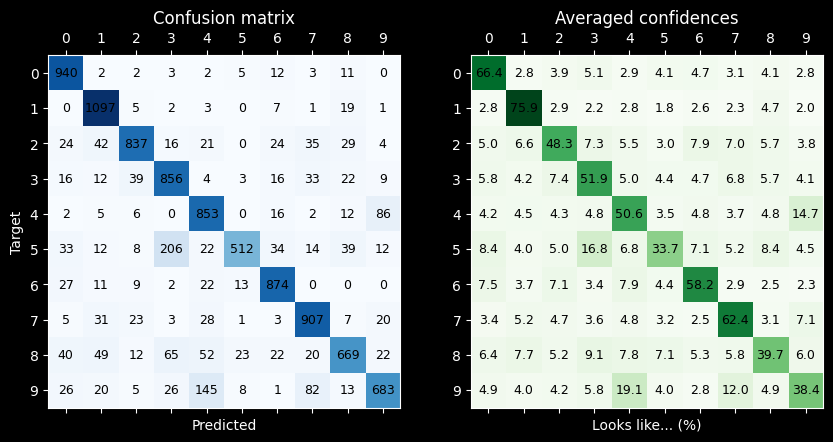

In [ ]:
# строим матрицу ошибок
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

# матрица ошибок
ax0.set_title('Confusion matrix')
ax0.matshow(confusion_matrix, cmap='Blues')

for i in range(number_of_classes):
    for j in range(number_of_classes):
        val = confusion_matrix[j, i].item()
        ax0.text(
            i, j, str(val),
            va='center', ha='center',
            c='k', fontsize=9
        )

ax0.set_ylabel('Target')
ax0.set_xlabel('Predicted')

ax0.set_xticks(range(number_of_classes))
ax0.set_yticks(range(number_of_classes))

# усредненные вероятности классов
ax1.set_title('Averaged confidences')
ax1.matshow(avg_probas_mat, cmap='Greens')

for i in range(number_of_classes):
    for j in range(number_of_classes):
        val = avg_probas_mat[j, i].item()
        ax1.text(
            i, j, f'{val * 100:.1f}',
            va='center', ha='center',
            c='k', fontsize=9
        )

ax1.set_xlabel('Looks like... (%)')

ax1.set_xticks(range(number_of_classes))
ax1.set_yticks(range(number_of_classes))
# ax1.set_yticks(range(number_of_classes), labels=['' for _ in range(number_of_classes)])

plt.show()

# save figure
# fig.savefig(f'{RESULTS_FOLDER}/confusion_matrix.png', bbox_inches='tight')

### 5.6.2. Усредненный детектор для выбранного класса

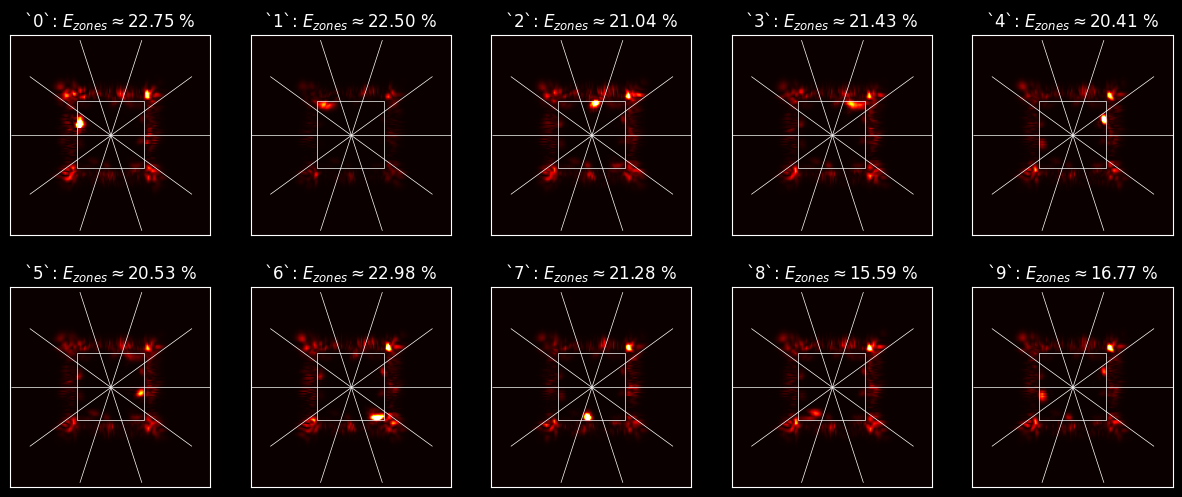

In [ ]:
n_cols = 5  # количество колонок для визуализации выходов детектора
n_rows = (number_of_classes // n_cols)

detector_cmap = 'hot'

# создаем фигуру с подграфиками
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

# выключаем ненужные оси
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= number_of_classes:
            ax_this.axis('off')

# строим волновые фронты
for selected_class in range(number_of_classes):
    ax_this = axs[selected_class // n_cols][selected_class % n_cols]

    # focus "efficiency"
    int_over_detector_zones = 0

    for ind_class in range(number_of_classes):
        int_over_detector_zones += detector_processor.batch_zone_integral(
            detector_sums_by_classes[selected_class].unsqueeze(0).unsqueeze(0),
            ind_class=ind_class,
        )[0].item()

    detector_int = detector_sums_by_classes[selected_class].sum().item()
    detector_efficiency = int_over_detector_zones / detector_int

    # выход детектора (не wavefront!)
    ax_this.set_title(
        f'`{selected_class}`: ' + r'$E_{zones}\approx$' +
        f'{detector_efficiency * 100:.2f} %'
    )
    ax_this.imshow(
        detector_sums_by_classes[selected_class] / samples_by_classes[selected_class],
        cmap=detector_cmap,
        vmin=0, vmax=0.02  # uncomment to make the same limits
    )

    for zone in get_zones_patches(selected_detector_mask):
        # add zone's patches to the axis
        # zone_copy = copy(zone)
        ax_this.add_patch(zone)

    ax_this.set_xticks([])
    ax_this.set_yticks([])

plt.show()

# save figure
# fig.savefig(f'{RESULTS_FOLDER}/averaged_detector_for_classes.png', bbox_inches='tight')

In [94]:
RESULTS_FOLDER

'models/03_mnist_experiments/13-12-2024_experiment_01'

### 5.6.3.  _Эффективность_ детектора

$$
\frac{\sum\limits_{\text{class}=0}^9 \left( \iint\limits_{S_\text{class}} I(x,y) \right)}{\iint\limits_{S_\text{detector}} I(x,y)}
$$

In [ ]:
detector_efficiency_by_classes = {}

for selected_class in range(number_of_classes):
    int_over_detector_zones = 0

    for ind_class in range(number_of_classes):
        int_over_detector_zones += detector_processor.batch_zone_integral(
            detector_sums_by_classes[selected_class].unsqueeze(0).unsqueeze(0),
            ind_class=ind_class,
        )[0].item()

    detector_int = detector_sums_by_classes[selected_class].sum().item()
    detector_efficiency_by_classes[selected_class] = int_over_detector_zones / detector_int

In [96]:
detector_efficiency_by_classes

{0: 0.2275042557075866,
 1: 0.225024240018919,
 2: 0.21037655863983734,
 3: 0.2142949430323286,
 4: 0.2040940627840348,
 5: 0.20525530429076602,
 6: 0.22981754325287346,
 7: 0.21275113301812842,
 8: 0.15594056278988472,
 9: 0.1676689237029004}